In [2]:
####### 
# This cell is meant to install packages if some are missing
#######

# !pip install tqdm scipy
# !pip install matplotlib
# !pip install opencv-contrib-python
# !pip install numpy
# !pip install --upgrade tdmclient

In [1]:
DEBUG = True


import matplotlib.pyplot as plt
import time
import numpy as np
from tqdm import tqdm
from kalmanfilter import KalmanFilter
import cv2   # a clean up
# import Motion_control as mc
import local_nav as ln
import math 
from Motion_control import MotionControl
from djikstra import djikstra_algo,create_plot
from calibration import data

### Connect the thymio(the speed set to 0 is here in case of an error during calibration or during the code)
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = aw(client.wait_for_node())
aw(node.lock())


#we initialize the calibration calss aswell as some values that are needed throughout the entire code
Ts = 0.1
SPEED_L = 101
SPEED_R = 99
GND_THRESHOLD = 400

mc = MotionControl(node, client, Ts, SPEED_R, SPEED_L)  # A METTRE POUR TESTER DE FAIRE UNE CLASSE MOTION CONTROL
cal_data = data(Ts, SPEED_L, SPEED_R, GND_THRESHOLD, client, node)
mc.motors(0, 0)

# Calibration

In this section, we will run multiple functions, in order to calibrate our thymio to the current environement. This gives us more flexibility, and makes it easier to use different thymio in different environment.

### Calibration of the thymio 

In this first step, we will use the following image to calibrate the speed, its conversion ratio from the thymio's sensor to mm/s, and its variance for the Kalman filter.

<img src="Pictures/Picture1.jpg" width="900"/>

In this next function, we will ask the thymio to move forward, at a known speed. As soon as its ground sensor detect it is on the black line, it will start a timer. When it exits the line, the timer will stop, the thymio will stop aswell, and all the desired values will be computed. In this function, the line length is know and we need to be carefully align the thymio as to make it follow the line. From this test, we can also adjust the speed on the left and right wheel to make it go as straight as possible and adjust the transition threshold if the light's intensity in the current room requires it.

The following cell needs to be executed in order to initialize the calibration class, and start the calibration process. It will then give back the values in the form of a print, and give two functions we can replace the ones mentionned earlier. We have made it this way for debugging purposes. When changing code in other files that are imported, we need to restart the jupyter kernel and rerun all the cells to initialize everything. But we already know the values of the previous calibration, and if we are in the same room, with the same map and the same thymio, we know these value shouldn't change by a large margin. The two new functions will initialize everything, paste the values found earlier, and won't run the calibration process again. And if we need to change it back, the two  new functions, for the calibration process, would again be provided.

In [2]:
cal_data = data(Ts, SPEED_L, SPEED_R, GND_THRESHOLD, client, node, 0.32564826672561265, 2.553686829992469)
cal_data.calibration_mm(mc)

The conversion factor for the speed of the thymio to mm/sh is : 0.32564826672561265 
With a desired speed of : 99, the thymio speed is : 32.23917840583565 mm/s
The standard deviation from the speed state (q_nu) and speed measurement (r_nu) is : 2.553686829992469 
########################
YOU ARE IN A 'NO CALIBRATION' MODE. IF YOU WISH TO RUN CALIBRATION SEQUENCE, CHANGE THE CELL ABOVE WITH THIS CODE

cal_data = data(Ts, SPEED_L, SPEED_R, GND_THRESHOLD, client, node)
cal_data.calibration_mm(mc)
########################


### Calibration of the camera
In this next cell, we will retrieve the the grid from the camera, and do all the conversions requiered for the rest of the project. 

We initialize the vision class here, with a calibration function, because of the light's density in our current room. We often needed to adjust the threshold for multiple detection process in this class. We could've automated the process, but have decided against it, as it never was a time-consuming task. We would usually run the cell bellow with the DEBUG defined as true, check the number of obstacles, and from this, we immediatly knew what to do with our threshold value, and change it once, or twice at the very maximum.

Number of obstacles =  9
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


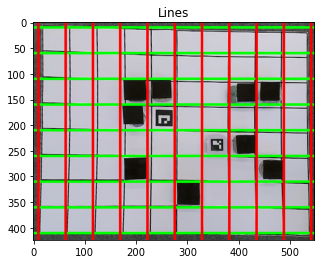

In [4]:
# be careful that if you have not called the previous sell, this will automatically set the missing values
nbAruco = 2
threshold = 50
calibrate = False
vision, Q_cam, R_cam, Q_gnd, R_gnd = cal_data.cam_calibration(calibrate, nbAruco, threshold)

HALF_CELL_WIDTH = vision.cell_width/2
if(DEBUG == True):
    print("Number of obstacles = ", np.count_nonzero(vision.grid))
    print(vision.grid)
    lines = vision.show()
    plt.figure
    plt.title('Lines')
    plt.imshow(cv2.cvtColor(lines.astype('uint8'), cv2.COLOR_BGR2RGB))


### Kalman's filter

The filter we have chosen to use is the kalman's filter. With the use of the camera, and the thymio's speed sensor, we have two different sensor with which we can use the Kalman's filter. It's implementation is traditionnal. Again, we have gone for the usage of a class, as it makes it easier to use, and track the values. 
The one section where we had room to play with, were the values of the covariance of process noise's matrices Q, and the values of the covariance of the measurement's noise R.

 $R = \begin{bmatrix} r_p & 0\\ 0 & r_\nu \end{bmatrix}$
 $Q = \begin{bmatrix} q_p & 0\\ 0 & q_\nu \end{bmatrix}$

The values have been computed using the same method as in the exercise of week 8. The $r_\nu$ and $q_\nu$ have been computed inside the calibration process. For $q_p$ and $r_p$, it was a little bit more difficult. An issue we had, was the deformation of the image due to the lens, and the position of the camera. 

<img src="Pictures/Camera_pos.jpg" />

When placing the camera, we always placed it perfectly in the middle of the grid along its x axis, but because of our setup, we could never place it in the middle of its width along the y axis aswell. It was always on the side. This induced an error on the y position of the thymio. We have fixed it by placing a y_offset in the vision class. With this offset, we managed to correct the position in y from the camera's perspective, but it wasn't perfect either. We still had an error of approximatively ±5mm. Based on the exercise of week 8 again, we decided to set $r_p$ = XXXXX But while testing this, we also managed to see the variance on the position from the camera's perspective. We found from this that the standard deviation was 0.5mm, so we have set $q_p$ =  0.25mm


### Run code

Now that everything has been explained, we simply need to run the cell bellow to execute thymio's task.



In [ ]:
#######
# The following values have been set in the calibration part
# 
# Ts = 0.01
# SPPED_X = 101
# SPPED_0 = 100
# GND_THRESHOLD = 400
# If a preview is needed, run the following command
#
# print(f" The sampling time is : {Ts} s \n The speed is : {SPEED} mm/s \n The transition threshold is : {GND_THRESHOLD} \n")¨
# 
#######
#  The following values are the results of the calibration part 
#
# q_nu 
# r_nu
# conversion
# 
# print(f"The conversion factor for the speed of the thymio in mm/s is : {conversion} ")
# print(f"The standard deviation from the speed state (q_nu) and speed measurement (r_nu) is : {std_speed} ")
#######


thymio real pos :  [[950.02358491]
 [487.225     ]]
thymio pos in grid :  (6, 4)
goal pos :  (4, 3)
thymio angle = : 92.38594403038883
[[6 5 4 4]
 [4 4 4 3]]


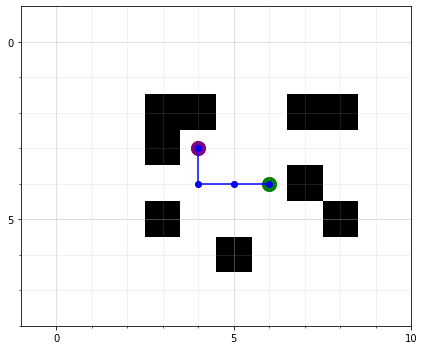

In [5]:
vision.update_coordinates()
if(DEBUG == True):
    print("thymio real pos : ", vision.thymio_real_pos)
    print("thymio pos in grid : ", vision.thymio_position)
    print("goal pos : ", vision.goal_position)
    print("thymio angle = :", vision.thymio_orientation)
vision.grid[vision.thymio_position[1]][vision.thymio_position[0]] = 0
vision.grid[vision.goal_position[1]][vision.goal_position[0]] = 0
shortest_path = djikstra_algo(vision.grid.T, vision.thymio_position, vision.goal_position)
if(DEBUG == True):
    print(shortest_path)

KF = KalmanFilter(Ts, vision.thymio_real_pos, cal_data.speed_conversion, Q_cam, Q_gnd, R_cam, R_gnd)  # we initialize the filter

In [ ]:
mc.motors(0, 0)

In [6]:
mc.step_duration = HALF_CELL_WIDTH*2 / (mc.SPEED_AVG * mc.speed_conversion)  # a mettre dans la classe
mc.turn_duration = 98 / (mc.SPEED_AVG * mc.speed_conversion)
orientation = mc.correct_orientation(vision.thymio_orientation)
x = vision.thymio_position[0]
y = vision.thymio_position[1]
speed = np.array([SPEED_L, SPEED_R])
turn_speed = np.array([0, 0])
# A TOUT METTRE DANS MOTION CONTROL
jump = False
jump_x,jump_y = 0,0
kalmann_pos_x, kalmann_pos_y = 0,0
ajdust = 0
index = 0
MARGIN = 40
for dx,dy in np.transpose(shortest_path):
    if jump:
        x = dx      #actualize the coordinates of the robot
        y = dy      #actualize the coordinates of the robot
        index += 1
        if jump_x == dx and jump_y == dy:
            jump = False
        continue
    
    #faire une fonction de rotation pure
    vision.update_coordinates()  
    if(vision.thymio == True): # faire que si on voit le thymio
        angle = vision.thymio_orientation # angle of the robot
        if((orientation == 0) & (angle > 270)):  
            adjust_angle = angle - 360
        else:
            adjust_angle = angle - orientation*90 
        # if(DEBUG == True):
        #     print("adjust angle before moving :", adjust_angle)   
        turn_speed[0] = int(SPEED_L*np.sign(adjust_angle))
        turn_speed[1] = int(-SPEED_R*np.sign(adjust_angle))
        mc.motors(turn_speed[0], turn_speed[1])
        aw(client.sleep(5*abs(adjust_angle)//180)) # a changer pour un check sur time ?
        mc.motors(0, 0)
        
    turn = mc.get_turn(dx-x,dy-y,orientation)
    orientation = (orientation + turn)%4
    for i in range(abs(turn)):
        mc.robot_turn(np.sign(turn))
    if (((dx-x)!=0) | ((dy-y)!=0)):
        local = ln.obstacle_detect(node)
        if local:
            if(DEBUG == True):
                print("obstacle",len(shortest_path[1]))
            if (index+2) > len(shortest_path[1]):
                jump,jump_x,jump_y,orientation = ln.obstacle_avoid(x,y,orientation, shortest_path,  len(shortest_path[1]), speed, mc.step_duration, cal_data.speed_conversion, node, client)
            else:
                jump,jump_x,jump_y,orientation = ln.obstacle_avoid(x,y,orientation, shortest_path, index, speed, mc.step_duration, cal_data.speed_conversion, node, client)
        else:   
            if (((dx-x)!=0) | ((dy-y)!=0)):
                step_done = False
                start_move = time.time()
                mc.motors(speed[0], speed[1])
                temp = 0
                next_target_x = dx *HALF_CELL_WIDTH*2 + HALF_CELL_WIDTH
                next_target_y = (vision.rows - 1 - dy) *HALF_CELL_WIDTH*2 + HALF_CELL_WIDTH
                
                while (step_done != True):  
                    vision.update_coordinates()
                    kalman_pos= KF.filter(vision.thymio, vision.thymio_real_pos, orientation, speed, vision.thymio_orientation, 0, 0, GND_THRESHOLD)  # A CHANGER AVEC LES VRAIES VALEURS
                    # if(DEBUG == True):
                    #     print("estimated position ", kalman_pos)
                    #     print("position from camera ", vision.thymio_real_pos)
                    delta_x, delta_y, adjust_turn = mc.kalman_adjust(next_target_x, next_target_y, kalman_pos, vision.thymio_orientation)
                    correcting_speed_x = speed[0] - adjust_turn
                    correcting_speed_y = speed[1] + adjust_turn
                    # if(DEBUG == True):
                    #     print((correcting_speed_x, correcting_speed_y))
                    mc.motors(correcting_speed_x, correcting_speed_y)
                    aw(client.sleep(2*Ts))
                    mc.motors(speed[0], speed[1])
                    current = time.time()
                    temp = current - start_move
                    if((np.abs(delta_x) < MARGIN) & (np.abs(delta_y) < MARGIN)):
                        step_done = True
                        mc.motors(0, 0) 
                    elif(temp > mc.step_duration):
                        step_done = True  
                        mc.motors(0, 0)
            # vision.update_coordinates()  #camera_check()
            # if(vision.thymio == True):
            #     angle = vision.thymio_orientation #angle of the robot
            #     if((orientation == 0) & (angle > 270)): # faire que si on voit le thymio
            #         adjust_angle = angle - 360
            #         print(" -360", angle)
            #     else:
            #         adjust_angle = angle - orientation*90 
            #         print("else", angle)
            #     if(DEBUG == True):
            #         print("adjust angle ", adjust_angle)
            #     if(adjust_angle > 0.00001):
            #         turn_speed[0] = int(SPEED_L*np.sign(adjust_angle))
            #         turn_speed[1] = int(-SPEED_R*np.sign(adjust_angle))
            #         mc.motors(turn_speed[0], turn_speed[1])
            #         aw(client.sleep(5*abs(adjust_angle)//180))
            #         mc.motors(0, 0)
            # turn = mc.get_turn(dx-x, dy-y, orientation)
            # orientation = orientation + turn
        
            #
            #étape de correction entre l'estimation et le goal avant de passer à la step suivante
            #

    x = dx      #actualize the coordinates of the robot
    y = dy      #actualize the coordinates of the robot
    index += 1
    



ERROR MESSAGE: the Thymio robot was not detected
ERROR MESSAGE: the Thymio robot was not detected
ERROR MESSAGE: both the Thymio robot and the goal were not detected
ERROR MESSAGE: the goal was not detected
ERROR MESSAGE: the goal was not detected
ERROR MESSAGE: the goal was not detected
ERROR MESSAGE: both the Thymio robot and the goal were not detected
ERROR MESSAGE: the goal was not detected
ERROR MESSAGE: the goal was not detected
ERROR MESSAGE: the goal was not detected


In [ ]:

import math
import numpy as np
import computer_vision as av
vision = av.Vision(100)

In [ ]:
step_duration = HALF_CELL_WIDTH*2 / (mc.SPEED_AVG * cal_data.speed_conversion)
start = time.time()
mc.motors(node, SPEED_L, SPEED_R)
aw(client.sleep(step_duration))
mc.motors(node, 0, 0)

In [ ]:
DEBUG = True



import matplotlib.pyplot as plt
import time
import numpy as np
from tqdm import tqdm
from kalmanfilter import KalmanFilter
import cv2   # a clean up
import Motion_control as mc
import local_nav as ln

#import computer_vision
from djikstra import djikstra_algo,create_plot
from calibration import data

### Connect the thymio(the speed set to 0 is here in case of an error during calibration or during the code)
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = aw(client.wait_for_node())
aw(node.lock())


#we initialize the calibration calss aswell as some values that are needed throughout the entire code
Ts = 0.01
SPEED_L = 101
SPEED_R = 100
SPEED_AVG = (SPEED_L + SPEED_R)/2
GND_THRESHOLD = 400

cal_data = data(Ts, SPEED_L, SPEED_R, GND_THRESHOLD, client, node)
mc.motors(node, 0, 0)

In [ ]:
start1 = time.time()
i = 0
while(i < 5):
    i = i+1
    current1 = time.time()
    temp = start1-current1
    time.sleep(2)
    print(temp)

In [ ]:
import matplotlib.pyplot as plt
import time
import numpy as np
from tqdm import tqdm
from kalmanfilter import KalmanFilter
import cv2   # a clean up
import Motion_control as mc
import local_nav as ln

#import computer_vision
from djikstra import djikstra_algo,create_plot
from calibration import data

max_val_x = 15 # Size of the map
max_val_y = 20 # Size of the map
start = (1,1)
goal = (9,14)
np.random.seed(0) # To guarantee the same outcome on all computers
data = np.random.rand(max_val_x, max_val_y) * 20 # Create a grid of 50 x 50 random values
data = create_plot(max_val_x,max_val_y,data,start,goal)
shortest_path = djikstra_algo(data,start,goal)
print(shortest_path)

In [ ]:
mc.motors(node, 0, 0)

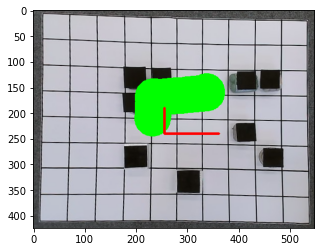

In [8]:
def compare_path(shortest_path, vision):
    shortest_path_img = np.array([(shortest_path[0] + 1)*vision.cellx - vision.offset, (shortest_path[1] + 1)*vision.celly - vision.offset])
    path = cv2.imread('output/transformedImage.png', cv2.IMREAD_COLOR)
    for p in vision.thymio_list_pos:
        cv2.circle(path, (int(p[0][0]/vision.conversion_factor_x), int(p[1][0]/vision.conversion_factor_y)), 20, (0,255,0), 30)

    for c in range(1, len(shortest_path_img[0])):
        cv2.line(path, (shortest_path_img[0][c-1], shortest_path_img[1][c-1]), 
                        (shortest_path_img[0][c], shortest_path_img[1][c]), (0,0,255), 3)
    return path

path = compare_path(shortest_path, vision)

plt.figure
plt.imshow(cv2.cvtColor(path.astype('uint8'), cv2.COLOR_BGR2RGB))

We can see that the path has been properly computed. For the path's compution we needed the start and end point. As the kalman initialization also requires the starting point, we have decided to also initialize the filter at this point of the code.

changer pour du 
move
start = time.time()

vbla bla bla

current = time.time()
if current-start == temps pour la durée désirée

alors on passe à l'étape suivante





jouer avec la mesure de la vitesse sur la phase de calibration

